# Symbolic Differentiation

Symbolic differentiation mimics programmatically what you do by hand when calculating derivatives.
It works by building up a representation of the mathematical expression that you want to differentiate.  This is called an *expression tree*.  
Expression trees are made out of nodes that can be either operators or operands.
Operators are things like +, -, *, /, or functions like sin, cos, exp, log, etc.
Operands are things like numbers, variables, or other expressions.

For example, the expression:

$$
f(x) = 1 + x^2
$$

would be represented by the following expression tree.
We have highlighted with operators with red and operands with blue.

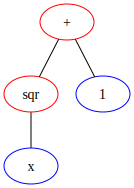

In [15]:
import graphviz

g = graphviz.Digraph(edge_attr={'arrowhead': 'none'})

g.node('+', color='red')
g.node('sqr', color='red')
g.node('1', color='blue')
g.node('x', color='blue')
g.edge('+', '1')
g.edge('+', 'sqr')
g.edge('sqr', 'x')
g

Here is an expression tree for:

$$
f(x,y) = \left(\frac{\sin x}{x}\right)^2 + y^3.
$$

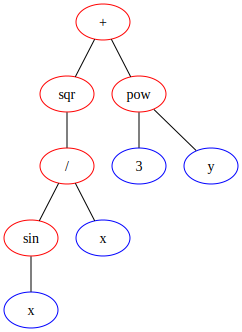

In [49]:
g = graphviz.Digraph(edge_attr={'arrowhead': 'none'})

g.node('+', color='red')
g.node('sqr', color='red')
g.node('sin', color='red')
g.node('pow', color='red')
g.node('/', color='red')
g.node('3', color='blue')
# make two different nodes for x
g.node('x1', color='blue', label='x')
g.node('x2', color='blue', label='x')
g.node('y', color='blue')

g.edge('sin', 'x1')
g.edge('/', 'sin')
g.edge('/', 'x2')
g.edge('sqr', '/')
g.edge('+', 'sqr')
g.edge('+', 'pow')
g.edge('pow', '3')
g.edge('pow', 'y')

g

You get the idea.

One of the first thing that we would like to do is evaluate the expression.
Here is pseudocode for how to evaluate an expression tree:

```python
    def evaluate(node):
        if node is an operator:
            evaluate the operands
            apply the operator to the operands
            return the result
        else:
            return the value of the operand
```

Similarly, we can write generic code to differentiate an expression tree with respect to a variable.
To write such code, we need to know the derivative of each operator and the chain rule.
For example, the derivative of the addition operator is:

$$
\partial_x (f + g) = \partial_x f + \partial_x g.
$$

Here we are using the notation $\partial_x f$ to mean the gradient of $f$ with respect to the variable $x$, i.e., $\partial_x f = \frac{\partial f}{\partial x}$.

Similarly, for the multiplication operator:

$$
\partial_x (f g) = f \partial_x g + g \partial_x f.
$$

And so on for all operators.

Equipped with these basic operations, we can write a generic function to differentiate an expression tree with respect to a variable:

```python
    def differentiate(node, variable):
        if node is an operator:
            differentiate the operands
            apply the derivative rule for the operator to the operands
            return the result
        else:
            if node is the variable:
                return 1
            else:
                return 0
```

If you want to learn more about this, I suggest you read [Structure and Interpretation of Computer Programs (SICP) by Abelson and Sussman](https://mitpress.mit.edu/sites/default/files/sicp/full-text/book/book.html).

The Python package `sympy` is a library for symbolic mathematics.
Let's use it to build these trees.

In [30]:
import sympy
from sympy.abc import x, y

f = (sympy.sin(x) / x) ** 2 + y ** 3

f

y**3 + sin(x)**2/x**2

Here is the expression tree as it is internally represented by `sympy`.

In [28]:
sympy.srepr(f)

"Add(Pow(Symbol('y'), Integer(3)), Mul(Pow(Symbol('x'), Integer(-2)), Pow(sin(Symbol('x')), Integer(2))))"

You can evaluate the expression tree:

In [32]:
f.evalf(subs={x: 1, y: 2})

8.70807341827357

Or you can make a python function that evaluates the expression tree at any point:

In [33]:
f_func = sympy.lambdify([x, y], f)

f_func(1, 2)

8.708073418273571

And of course, you can differentiate the expression tree:

In [34]:
# Differentiate with respect to x
pxf = f.diff(x)
pxf

2*sin(x)*cos(x)/x**2 - 2*sin(x)**2/x**3

And you can evaluate that anywher you want:

In [35]:
pxf_func = sympy.lambdify([x, y], pxf)

pxf_func(1, 2)

-0.5068494097214605

There are a few problems with this approach.
First, it is hard to differentiate through loops and conditionals symbolically.
This restricts quite a bit the kind of functions that you can differentiate.
Second, the expression trees can get quite large and complicated very quickly.
This is called the *expression swell* problem.

Here is an example of expression swell.
We use the soft relu function nested a few times:

In [42]:
w, b = sympy.symbols('w b')
# Soft relu
f = sympy.log(1 + sympy.exp(w * x + b))
f

log(exp(b + w*x) + 1)

Here is the gradient of this function with respect to $w$:

In [43]:
f.diff(w)

x*exp(b + w*x)/(exp(b + w*x) + 1)

Now let's nest the soft relu function a few more times:

In [44]:
f2 = sympy.log(1 + sympy.exp(w * f + b))
f2

log(exp(b + w*log(exp(b + w*x) + 1)) + 1)

Here is the derivative now:

In [46]:
f2.diff(w)

(w*x*exp(b + w*x)/(exp(b + w*x) + 1) + log(exp(b + w*x) + 1))*exp(b + w*log(exp(b + w*x) + 1))/(exp(b + w*log(exp(b + w*x) + 1)) + 1)

Okay, one more time to make the point:

In [47]:
f3 = sympy.log(1 + sympy.exp(w * f2 + b))
f3

log(exp(b + w*log(exp(b + w*log(exp(b + w*x) + 1)) + 1)) + 1)

Differentiate:

In [48]:
f3.diff(w)

(w*(w*x*exp(b + w*x)/(exp(b + w*x) + 1) + log(exp(b + w*x) + 1))*exp(b + w*log(exp(b + w*x) + 1))/(exp(b + w*log(exp(b + w*x) + 1)) + 1) + log(exp(b + w*log(exp(b + w*x) + 1)) + 1))*exp(b + w*log(exp(b + w*log(exp(b + w*x) + 1)) + 1))/(exp(b + w*log(exp(b + w*log(exp(b + w*x) + 1)) + 1)) + 1)

You get it now.